In [1]:
from estimador import *
from filtros import *
from fit_voc import *
from functions import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

### Definimos los modelos a usar

In [2]:
param = dict(
    vL=1.35531394,
    v0=4.12017677,
    gamma=0.13286143,
    alpha=0.16945463,
    beta=2.34538224,
    Qmax=4.850,
    # Qmax=df.SoH.max(),
    Bias_Rint=0.01454392,
    Factor_Rint=0.1879029,
    life_cycles=938,
    adapt_cell=True,
    degradation_percentage=0.8
)

f_subc = FiltrosAnidados()
f_subc.Q_inst = param.get("Qmax")
f_subc.fit_batt_model(param)
f_subc.modelo_th.fit_inverse()
f_subc.voc_thresh = 0.05
f_subc.voc_times = 47
f_subc.sigma_autonomia = 0.04
f_subc.sigma_capacidad = 0.001 * 5
f_subc.estim_kwargs = {"sigma_e": 0.00075}

f_eqcycle = FiltrosAnidados()
f_eqcycle.Q_inst = param.get("Qmax")
f_eqcycle.fit_batt_model(param)
f_eqcycle.modelo_th.fit_inverse()
f_eqcycle.voc_thresh = 0.05
f_eqcycle.voc_times = 47
f_eqcycle.sigma_autonomia = 0.04
f_eqcycle.sigma_capacidad = 0.001 * 5
f_eqcycle.estim_kwargs = {"sigma_e": 0.00075}

if f_subc.modelo_th.parameters["adapt_cell"]:
    f_subc.modelo_th.adapt_degradation()
    f_subc.modelo_th.setup_knn()
    print("celda: f_subc adaptada")

if f_eqcycle.modelo_th.parameters["adapt_cell"]:
    f_eqcycle.modelo_th.adapt_degradation()
    f_eqcycle.modelo_th.setup_knn()
    print("celda: f_eqcycle adaptada")

# f_subcnom = FiltrosAnidados()
# f_subcnom.Q_inst = param.get("Qmax")
# f_subcnom.fit_batt_model(param)
# f_subcnom.modelo_th.fit_inverse()
# # Ajustamos los parámetros del estimaodor
# f_subcnom.voc_thresh = 0.05
# f_subcnom.voc_times = 47
# f_subcnom.sigma_autonomia = 0.04
# f_subcnom.sigma_capacidad = 0.001 * 5
# f_subcnom.estim_kwargs = {"sigma_e": 0.00075}

# f_subc = FiltrosAnidados()
# f_subc.Q_inst = param.get("Qmax")
# f_subc.fit_batt_model(param)
# f_subc.modelo_th.fit_inverse()
# # Ajustamos los parámetros del estimaodor
# f_subc.voc_thresh = 0.05
# f_subc.voc_times = 47
# f_subc.sigma_autonomia = 0.04
# f_subc.sigma_capacidad = 0.001 * 5
# f_subc.estim_kwargs = {"sigma_e": 0.00075}

modelo de celda seteado. Tabla de degradación:  {'100-0': [1.0], '100-25': [1.00000266], '75-0': [1.0000186], '100-50': [0.99999203], '75-25': [1.00001521], '50-0': [1.00002874], '100-75': [1.00002146], '75-50': [1.00000881], '62.5-37.5': [1.0000062], '50-25': [1.00003347], '25-0': [1.00004184]}
Parámetros del modelo:
{'A_Rint': 0.3084,
 'B_Rint': -0.2578,
 'Bias_Rint': 0.01454392,
 'C_Rint': -0.05083,
 'D_Rint': 0.1317,
 'Factor_R_SOH0': 0.28371948548,
 'Factor_R_SOH1': -0.57276721458,
 'Factor_R_SOH2': 0.32037195027000004,
 'Factor_R_SOH3': 0.02140399288,
 'Factor_Rint': 0.1879029,
 'Qmax': 4.85,
 'adapt_cell': True,
 'alpha': 0.16945463,
 'beta': 2.34538224,
 'degradation_data': {'100-0': [1.0],
                      '100-25': [1.00000266],
                      '100-50': [0.99999203],
                      '100-75': [1.00002146],
                      '25-0': [1.00004184],
                      '50-0': [1.00002874],
                      '50-25': [1.00003347],
                     

### Obtenemos el Ground Truth

In [3]:
# Obtenemos el ground truth
gt_path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset Stanford/W10/W10_diagnostics.csv"
gt_path_values = pd.read_csv(gt_path,header=None)
gt_path_values = gt_path_values.values

path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))
files.remove('C7.csv')

# Combine files and soh values into a df
data_values = [[file, SOH] for file, SOH in zip(files, gt_path_values[1:])]
column_names = ['file', 'SOH']
gt_df = pd.DataFrame(data_values, columns=column_names)

### Ejecutamos el modelo de degradación

In [4]:
file_path = os.path.join(path, "C1.csv")
columns_to_select = ["step_ind","SoC"]
df = pd.read_csv(file_path,usecols=columns_to_select)

## Actualizamos la capacidad máxima de cada modelo
f_subc.Q_inst = param.get("Qmax")
f_eqcycle.Q_inst = param.get("Qmax")
# f_subc.Q_inst = param.get("Qmax")
# f_subcnom.Q_inst = param.get("Qmax")

## Iniciamos las configuraciones para el proceso de filtrado
path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))
files.remove('C7.csv')
print(files)

## Iniciamos las variables del modelo

## Variables globales
Q_healthy = param.get("Qmax")

## Variables método eq_cycle
dsoc_eqcycle = 0
soc_acc = 0
soc_inst_eqcycle = df.SoC.values[0]*100
soc_counting_eqcycle = [soc_inst_eqcycle]  # Initialize soc_counting list
step_counting_eqcycle = [df.step_ind.values[0]]  # Initialize soc_counting list
eqcycle_SoH_values = []

## Variables método subciclo nominal
dsoc_subc = 0
# dsoc_subcnom = 0
soc_inst_subc = df.SoC.values[0]*100
# soc_inst_subcnom = df.SoC.values[0]*100

extremos_subc = []
# extremos_subcnom = []
subc_SoH_values = []
# subcnom_SoH_values = []

## Variables método lineal
# lineal_soc_counting = [100,20]
# lineal_eta_k = f_lineal.get_factor(lineal_soc_counting,False) # generamos el eta
# lineal_SoH_values = [1]  # Initialize knn_SoH_values list

## Variables GT
gt_idx = 0
gt_soh_values = [gt_path_values[0][0]]  # Initialize knn_SoH_values list
gt_soh_idx = [gt_idx]

# Iterating through all the datasets
for file in files:
    if not file.endswith(".csv"):
        continue  # Skip files that are not CSV

    file_path = os.path.join(path, file)
    columns_to_select = ["step_ind","current","time","exp"]
    df = pd.read_csv(file_path,usecols=columns_to_select)

    gt_soh_value = gt_df.SOH.values[files.index(file)][0]
    gt_soh_values.append(gt_soh_value)
    gt_idx += round(len(df.current.values)/100)
    gt_soh_idx.append(gt_idx)

    for cnt, exp in enumerate(df.exp.unique()):
        print(file, cnt, end="\r")
        df_ = df[df.exp == exp]
        # Aplicamos eta al metodo lineal
        # f_lineal.Q_inst *= lineal_eta_k[0]  # Update f_gt.Q_inst

        # Iterate over the rows in the filtered DataFrame
        for ind, (c, dt, step,step_) in enumerate(zip(df_.current.values,
                                                    df_.time.values[1:] - df_.time.values[:-1],
                                                    df_.step_ind.values,
                                                    df_.step_ind.values[1:])):
            # hacemos conteo de coulomb
            dsoc_subc = dt * c / (f_subc.Q_inst * 36)
            dsoc_eqcycle = dt * c / (f_eqcycle.Q_inst * 36)

            # actualizamos el soc
            soc_inst_subc += dsoc_subc
            soc_inst_eqcycle += dsoc_eqcycle
            # limitamos los valores de soc
            if soc_inst_eqcycle >= 100:
                soc_inst_eqcycle = 100
                soc_counting_eqcycle.append(soc_inst_eqcycle)
            elif soc_inst_eqcycle < 0:
                soc_inst_eqcycle = 0
                soc_counting_eqcycle.append(soc_inst_eqcycle)
            else:
                soc_counting_eqcycle.append(soc_inst_eqcycle)

            if soc_inst_subc >= 100:
                soc_inst_subc = 100
            elif soc_inst_subc < 0:
                soc_inst_subc = 0

            # if soc_inst_subcnom >= 100:
            #     soc_inst_subcnom = 100
            # elif soc_inst_subcnom < 0:
            #     soc_inst_subcnom = 0
            
            ## implementación metodo eqcycle
            if dsoc_eqcycle < 0:
                soc_acc += dsoc_eqcycle
            if -100 >= soc_acc:
                eta_k_eqcycle = f_eqcycle.get_factor(soc_counting_eqcycle,unnml=False)
                f_eqcycle.Q_inst *= eta_k_eqcycle[0]
                soc_acc = 0
                soc_counting_eqcycle = []

            ## implementación metodos subciclo
            # Detección de minimo
            if ((step in [13, 14]) and (step_ not in [13, 14])):  
                extremos_subc.append(soc_inst_subc)
                # extremos_subcnom.append(soc_inst_subcnom)
            # Detección de máximo
            elif ((step not in [13, 14]) and (step_ in [13, 14])):  
                extremos_subc.append(soc_inst_subc)
                # extremos_subcnom.append(soc_inst_subcnom)

            if len(extremos_subc) == 2:
                ## actualizamos capacidad subciclo modificado
                eta_k_subc = eta_subciclo(extremos_subc, f_subc)
                f_subc.Q_inst *= eta_k_subc[0]
                ## actualizamos capacidad subciclo nominal
                # eta_k_subc_nom = eta_subciclo(extremos_subcnom, f_unadap)
                # f_unadap.Q_inst *= eta_k_subc_nom[0]
                extremos_subc = []
                # extremos_subcnom = []

            # actualización de SoH por método
            # lineal_SoH_values.append(f_lineal.Q_inst / Q_healthy)  # Append SoH value to knn_SoH_values 
            eqcycle_SoH_values.append(f_eqcycle.Q_inst / Q_healthy)  # Append SoH value to knn_SoH_values
            # subcnom_SoH_values.append(f_unadap.Q_inst / Q_healthy)  # Append SoH value to knn_SoH_values
            subc_SoH_values.append(f_subc.Q_inst / Q_healthy)  # Append SoH value to knn_SoH_values

['C1.csv', 'C2.csv', 'C3.csv', 'C4.csv', 'C5.csv', 'C6.csv', 'C8.csv', 'C9.csv', 'C10.csv', 'C11.csv', 'C12.csv', 'C13.csv', 'C14.csv']
etak desnormalizado a: [0.99977875]
calculo para subciclo:  [100, 20.008513221372144] eta =  [0.99977875]
eta normal:  [0.99972515]  aplicado
etak desnormalizado a: [0.99977876]
calculo para subciclo:  [100, 19.99038876989562] eta =  [0.99977876]
eta normal:  [0.99972845]  aplicado
etak desnormalizado a: [0.99977876]
calculo para subciclo:  [100, 19.971751082963774] eta =  [0.99977876]
eta normal:  [0.99972899]  aplicado
etak desnormalizado a: [0.99977877]
calculo para subciclo:  [100, 19.95299084504219] eta =  [0.99977877]
eta normal:  [0.99972878]  aplicado
etak desnormalizado a: [0.99977877]
calculo para subciclo:  [100, 19.940527517600433] eta =  [0.99977877]
eta normal:  [0.9997291]  aplicado
etak desnormalizado a: [0.99977878]
calculo para subciclo:  [100, 19.916494747999778] eta =  [0.99977878]
eta normal:  [0.99972913]  aplicado
etak desnormali

### Graficamos los resultados

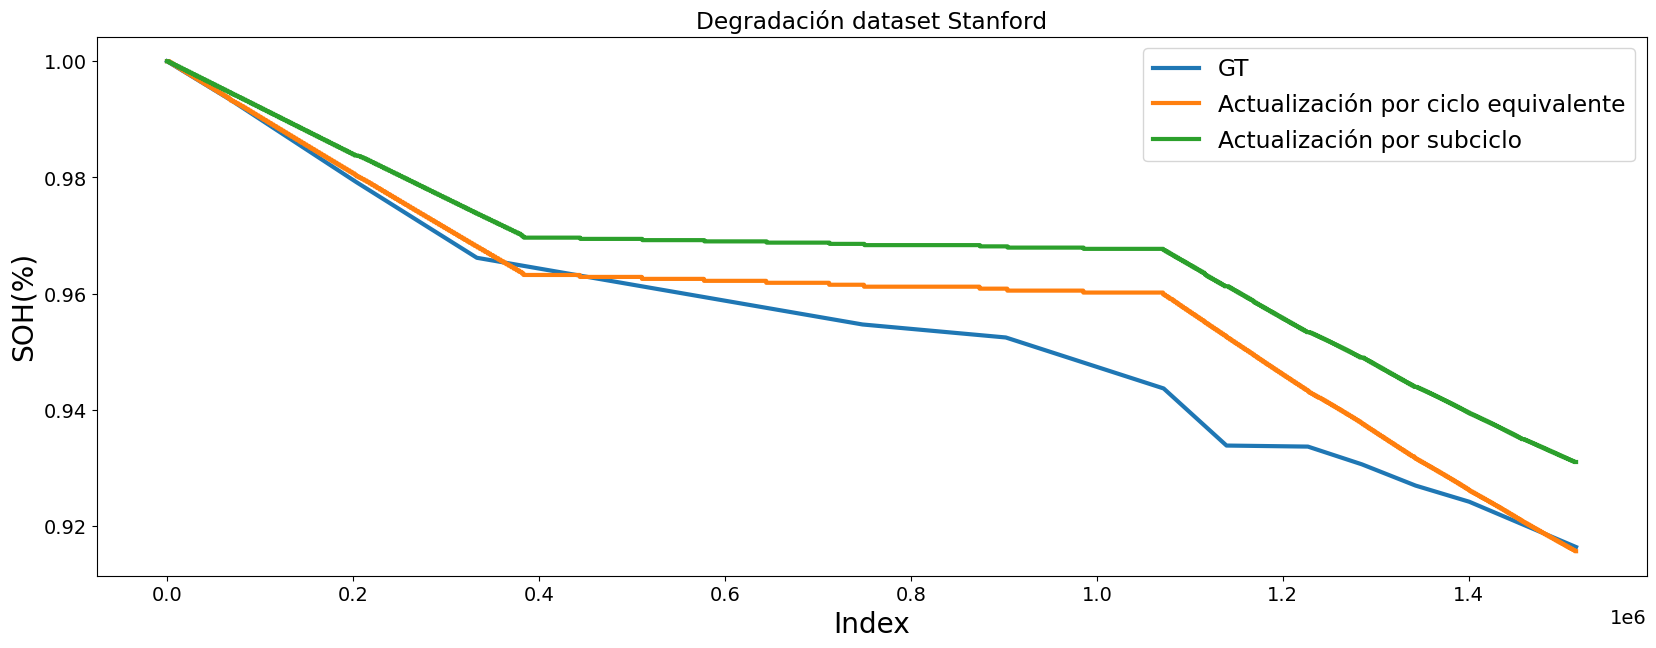

In [5]:
# lineal = lineal_SoH_values[::100]
eqcycle = eqcycle_SoH_values[::100]
# subcnom = subcnom_SoH_values[::100]
subc = subc_SoH_values[::100]

plt.figure(figsize=(20, 7))

plt.plot(gt_soh_idx,gt_soh_values, label="GT")
# plt.plot(lineal, label='Metodo lineal')
# plt.plot(maxmin, label='Metodo maxmin')
plt.plot(eqcycle, label='Actualización por ciclo equivalente')
plt.plot(subc, label='Actualización por subciclo')

plt.title("Degradación dataset Stanford")
plt.xlabel("Index")
plt.ylabel("SOH(%)")
plt.legend()
plt.show()